So turns out tongue archives are stored as 256x256 which can be directly scaled on top of the video.

In [44]:
import sys
sys.path.append("/Users/eric/Workspace/wangLab/orofacial")

import orofacial

#h5_path = "data/PCRt_2024_07011_right_2_tongue.h5"
h5_path = "data/PCRt_2024_07011_left_2_tongue.h5"

h5 = orofacial.tongue_mask_processing.TongueArchive(h5_path)
display(len(h5.frames))
display(h5.frames[0:5])



15662

array([   4, 1323, 1327, 1328, 1362])

100%|██████████| 15662/15662 [00:01<00:00, 8217.88it/s]


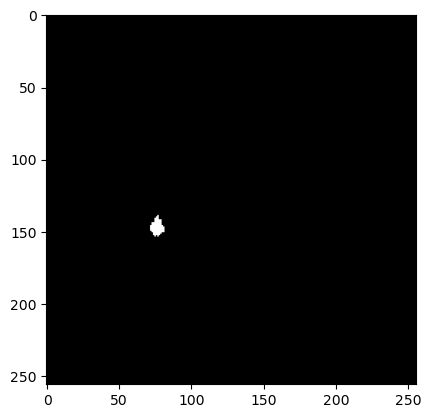

In [45]:
import tqdm
from matplotlib import pyplot as plt

imgs = []

for i in tqdm.tqdm(range(len(h5.frames))):
    imgs.append((orofacial.tongue_mask_processing.plot_frame_bool(h5, i, 256, 256), h5.frames[i]))

plt.imshow(imgs[1000][0], cmap='gray')

    

In [46]:
import numpy as np

# removing images with less than 15 pixels as preprocessing step
imgs = list(filter(lambda x : np.count_nonzero(x[0]) > 60, tqdm.tqdm(imgs)))

100%|██████████| 15662/15662 [00:00<00:00, 110022.96it/s]


In [47]:
imgs = list(map(lambda x : (orofacial.tongue_mask_processing.keep_largest_cc(x[0].astype(np.uint8)).astype(np.bool_), x[1]), tqdm.tqdm(imgs)))

100%|██████████| 6325/6325 [00:02<00:00, 3061.67it/s]


In [48]:
coords = list(map(lambda x : orofacial.tongue_tip_track_2D.find_tongue_tip_no_dist(x[0], np.array([-1, 0], dtype=np.float32)), tqdm.tqdm(imgs)))

100%|██████████| 6325/6325 [00:06<00:00, 1022.85it/s]


In [49]:

import matplotlib.pyplot as plt
import numpy as np

for i in range(len(coords)):
    if coords[i][0] < 50 or coords[i][1] < 90:
        plt.imsave(f"output/problem_tongue_{i}.png", imgs[i][0])

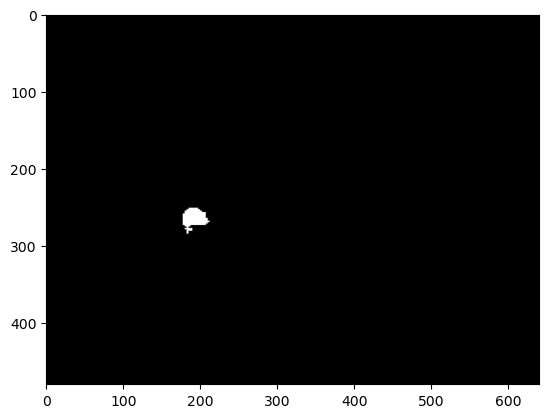

In [50]:
from matplotlib.patches import Rectangle

plt.imshow(imgs[20][0], extent=[0, 640, 480, 0], cmap="gray")


In [51]:
plt.imsave("output/tongue.png", imgs[20][0], cmap="gray")

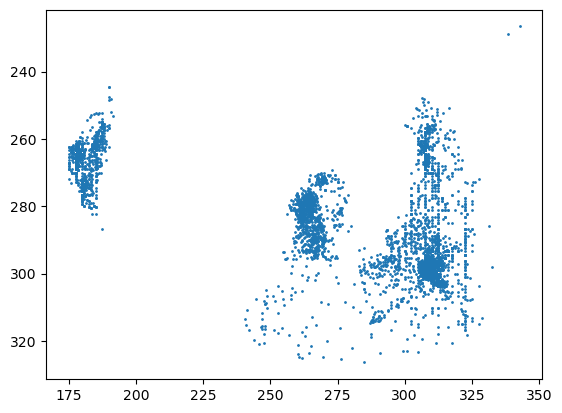

In [52]:
#c = list(filter(lambda x : x[0] > 225*256//640, coords))
c = coords
x, y = np.column_stack(c)
plt.gca().invert_yaxis()
plt.scatter(x*(640/256), y*(480/256), s=1)
coords = c


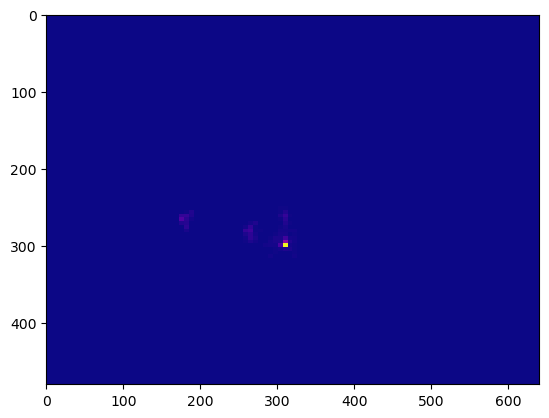

In [53]:
import matplotlib.pyplot as plt
import numpy as np
bad = 0

# heatmap
x, y = np.column_stack(coords)
heatmap, xedges, yedges = np.histogram2d(x, y, range=[[0, 256], [0, 256]], bins=(100, 100))

plt.clf()
plt.imshow(heatmap.T, extent=[0, 640, 480, 0], origin='upper', cmap="plasma")

def set_zoom():
    plt.gca().set_xlim([150, 400])
    plt.gca().set_ylim([450, 150])
    plt.gca().set_box_aspect(1)

plt.show()



In [54]:
imgs, coords = zip(*list(filter(lambda x : x[1][0] > 90, zip(imgs, coords))))
print(imgs, coords)

((array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 2880), (array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 2881), (array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False

Assumption that each lick is separated by a consecutive window of empty frames

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:51<00:00, 19.29it/s]
ffmpeg version 4.4.2 Copyright (c) 2000-2021 the FFmpeg developers
  built with clang version 14.0.6
  configuration: --prefix=/Users/runner/miniforge3/conda-bld/ffmpeg_1671040356584/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_pl --cc=arm64-apple-darwin20.0.0-clang --cxx=arm64-apple-darwin20.0.0-clang++ --nm=arm64-apple-darwin20.0.0-nm --ar=arm64-apple-darwin20.0.0-ar --disable-doc --disable-openssl --enable-avresample --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libfontconfig --enable-libopenh264 --enable-cross-compile --arch=arm64 --target-os=darwin --cross-prefix=arm64-apple-darwin20.0.0- --host-cc=/Users/runner/miniforge3/conda-bld/ffmpeg_1671040356584/_build_env/bin/x86_64-apple-darwin13.4.0-clang --enable-neon --enable-gnutls --enable-libmp3lame 

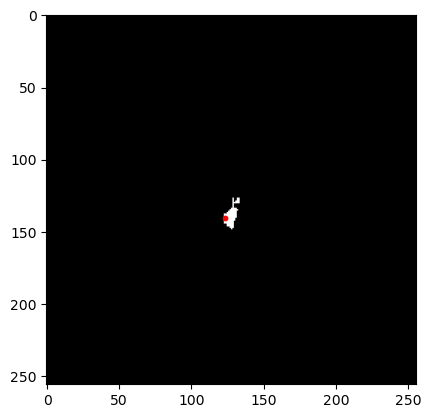

In [55]:
from random import randint
import os, subprocess, glob
def generate_video(img):
    os.chdir("output")
    for i in tqdm.tqdm(range(1000)):
         plt.clf()
         plt.imshow(img[i][0], cmap="gray")
         plt.scatter(x = coords[i][0], y = coords[i][1], c = "r", s = 10);
         plt.savefig("file%02d.png" % i)

    subprocess.call([
        'ffmpeg', '-framerate', '8', '-i', 'file%02d.png', '-r', '60', '-pix_fmt', 'yuv420p',
        f'video_name{randint(1, 1000000000)}.mp4'
    ])
    for file_name in glob.glob("*.png"):
        os.remove(file_name)
    os.chdir("../")

generate_video(imgs)


In [56]:

licks = [[coords[0]]]
for i in range(1, len(coords)):
    if isinstance(coords[i], np.ndarray):
        if imgs[i][1] != imgs[i-1][1] + 1:
            licks.append([coords[i]])
        else:
            licks[-1].append(coords[i])

len(licks)

323

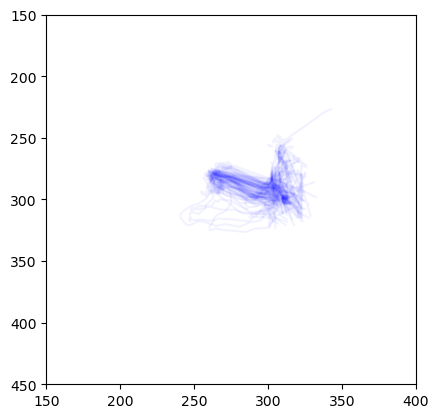

In [57]:
plt.gca().invert_yaxis()
for p in licks:
    x, y = np.column_stack(p)
    if len(x) > 4:
        plt.plot(x*(640/256), y*(480/256), alpha=0.05, c="blue")
set_zoom()
plt.show()

### Averaging tongue trajectories

Each curve is defined as a sequence of $(x_1, y_1),\ldots$

First curves will be parametized and fit to a spline for smoothing 

Parametization is normalized such that $1$ is always the end of the curve, no matter which.

The final curve will be the average of all curves through enumeration of the time variable. 


In [58]:
import scipy


def interp(p):
    tck, u = scipy.interpolate.splprep(np.column_stack(p), s=0, k=3) 
    t = np.linspace(0, 1, 100)  # Get 100 interpolated points
    x_new, y_new = scipy.interpolate.splev(t, tck)
    # Resulting interpolated trajectory (list of tuples)
    return list(zip(x_new, y_new))

licks_p = []
for i in range(len(licks)):
    #splprep cannot handle duplicate points
    p = [licks[i][0]]
    for j in range(1, len(licks[i])):
        if np.linalg.norm(np.array(licks[i][j]) - np.array(p[-1])) > 0.001:
            p.append(licks[i][j])
    if len(p) > 3:
        licks_p.append(interp(p))

display(len(licks_p))

118

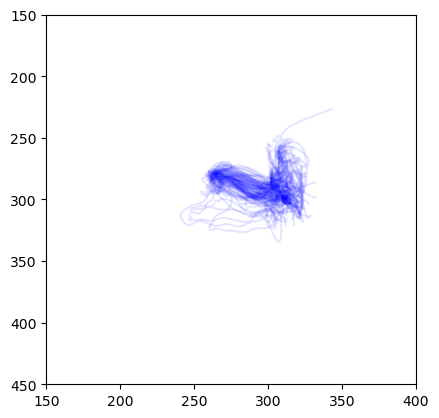

In [59]:
plt.gca().invert_yaxis()
for p in licks_p:
    x, y = np.column_stack(p)
    if len(x) > 4:
        plt.plot(x*(640/256), y*(480/256), alpha=0.1, c="blue")
set_zoom()
plt.show()

In [60]:
heatmap_licks = np.zeros((480, 640))

def interpolate_and_update_heatmap(start, end, heatmap, resolution):
    # Calculate the number of points needed for interpolation based on the distance
    num_points = max(abs(end - start)) * resolution
    # Generate interpolated points (including start and end)
    for t in np.linspace(0, 1, int(num_points)):
        interp_point = start + t * (end - start)
        x_idx, y_idx = interp_point
        x_idx = np.round(np.clip(x_idx*640/256, 0, 638)).astype(int);
        y_idx = np.round(np.clip(y_idx*480/256, 0, 478)).astype(int);
        heatmap[y_idx, x_idx] += 1  # Increment the heatmap value

for p in tqdm.tqdm(licks_p):
    prev = p[0]
    for curr in p[1:]:
        interpolate_and_update_heatmap(np.array(prev)[::-1], np.array(curr)[::-1], heatmap_licks, resolution=20)
        prev = curr



100%|██████████| 118/118 [00:02<00:00, 53.36it/s]


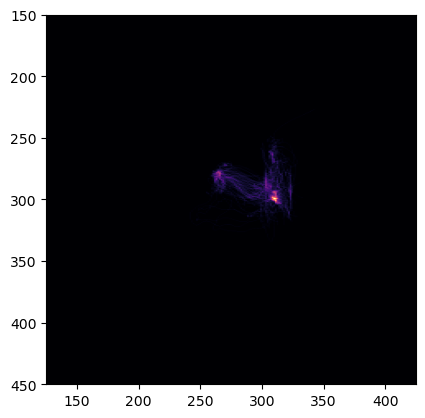

In [61]:
def show_heatmap_licks(heatmap):
    plt.imshow(heatmap.T, extent=[0, 640, 480, 0], cmap="magma")
    set_zoom()

show_heatmap_licks(heatmap_licks)

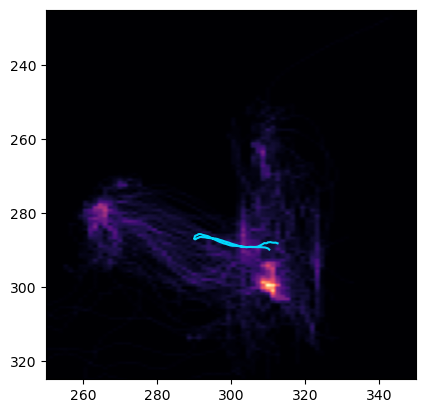

In [62]:
show_heatmap_licks(heatmap_licks)

avg_p = np.mean(licks_p, axis=0)
plt.plot(avg_p[:, 0]*(640/256), avg_p[:, 1]*(480/256), c="#03d7fc")

plt.gca().set_xlim([250, 350])
plt.gca().set_ylim([300, 250])
plt.gca().set_box_aspect(1)

In [63]:
licks_p_big = [p for p in licks_p if min(np.column_stack(p)[0])<120]
heatmap_licks_big = np.zeros((480, 640))
for p in tqdm.tqdm(licks_p_big):
    prev = p[0]
    for curr in p[1:]:
        interpolate_and_update_heatmap(np.array(prev)[::-1], np.array(curr)[::-1], heatmap_licks_big, resolution=20)
        prev = curr


100%|██████████| 60/60 [00:01<00:00, 36.52it/s]


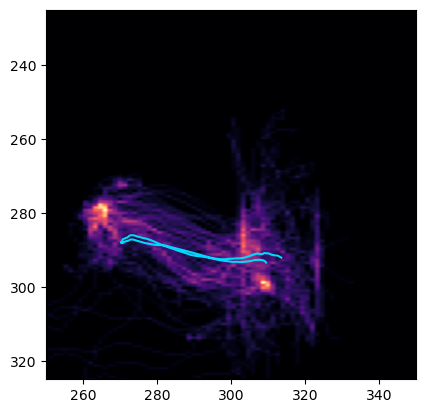

In [64]:
show_heatmap_licks(heatmap_licks_big)

avg_p = np.mean(licks_p_big, axis=0)
plt.plot(avg_p[:, 0]*(640/256), avg_p[:, 1]*(480/256), c="#03d7fc")

plt.gca().set_xlim([250, 350])
plt.gca().set_ylim([300, 250])
plt.gca().set_box_aspect(1)